In [72]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL.ImageDraw import ImageDraw
from scipy import ndimage, fft
from PIL import Image, ImageDraw

In [73]:
def get_image_array(file_name, print_info=False):
    image = Image.open(file_name)
    img = np.array(image)
    if print_info:
        print("filename:", image.filename)
        print("file format:", image.format)
        print("dtype:", img.dtype)
        print("shape:", img.shape)
        print()

    return img

In [74]:
def show_images(num_cols, per_image_size_px, *image_arrays, cmap="viridis", title=False):
    num_rows = int(len(image_arrays) / num_cols) + 1
    fig_size = (
        num_cols * (per_image_size_px / 100),
        num_rows * (per_image_size_px / 100),
    )
    fig = plt.figure(figsize=fig_size)
    for i, img in enumerate(image_arrays, 1):
        fig.add_subplot(num_rows, num_cols, i)
        if title:
            plt.imshow(img[0], cmap=plt.get_cmap(cmap))
            plt.title(img[1])
        else:
            plt.imshow(img, cmap=plt.get_cmap(cmap))
        plt.xticks([])
        plt.yticks([])

In [75]:
def rgb2gray(rgb):
    return np.rint(np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])).astype(np.uint8)

In [76]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

filename: pics/MenInDesert.jpg
file format: JPEG
dtype: uint8
shape: (552, 736, 3)



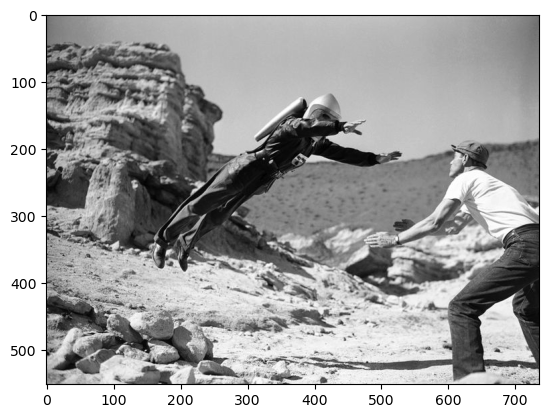

In [77]:
desert = get_image_array('pics/MenInDesert.jpg', True)
desert = rgb2gray(desert)
plt.imshow(desert, cmap="gray")

In [78]:
#  Original Image converted to grayscale

# Applying a Filter in Frequency Domain
def next_biggest_square(size):
    result = 2
    while(result < size):
        result*=2
    return result

def create_filter(size, low_frequ_value, high_frequ_value):
    scale_factor = 1.1
    e_x,e_y=size,size

    b_box = [(int(size*scale_factor) - size, int(size*scale_factor) - size), (size, size)]
    low_pass=Image.new("L",(int(size*scale_factor), int(size*scale_factor)) ,color=high_frequ_value)
    draw1=ImageDraw.Draw(low_pass)
    draw1.ellipse(b_box, fill=low_frequ_value)

    return np.transpose(np.array(low_pass))

def img_to_freq(img, size = 2):
    if size == 2:
        while(size < np.max(img.shape)):
            size*=2

    img = img.astype(float)
    return np.fft.fft2(img, (size, size))

def freq_to_img(freq):
    return np.abs(np.fft.ifft2(freq))

def apply_freq_filter(img, my_filter):
    img_spectrum = img_to_freq(img)
    filtered_img_spectrum = np.multiply(img_spectrum, img_to_freq(my_filter, np.max(img_spectrum.shape)))
    return freq_to_img(filtered_img_spectrum)

def convert_freq(freq):
    return (np.log(1+np.abs(np.fft.fftshift(freq))))

def show_spectrum(freq):
    plt.imshow(convert_freq(freq))

def crop_image(img,tol=0):
    # img is 2D image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

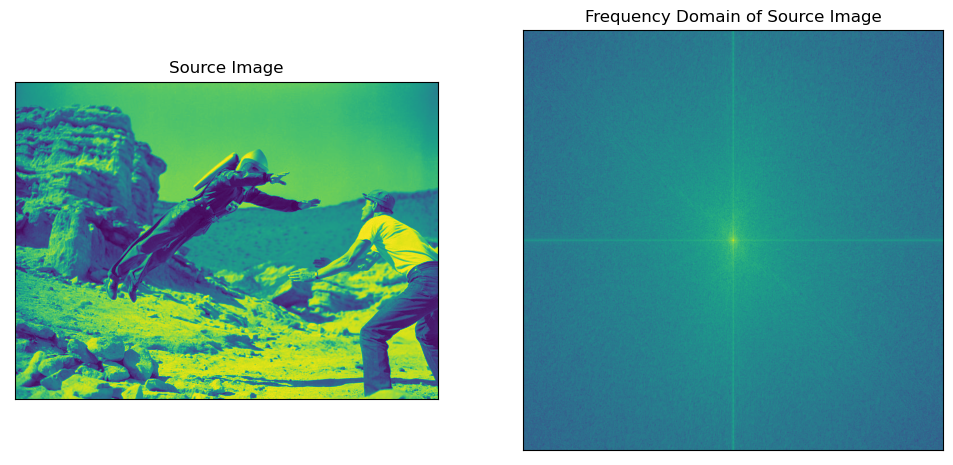

In [79]:
spectrum_desert = img_to_freq(desert)
show_images(2, 600, (desert, "Source Image"),
            (convert_freq(spectrum_desert), "Frequency Domain of Source Image"),
            title=True)

In [80]:
# Create low pass filter
def create_filter(size, low_frequ_value, high_frequ_value):
    scale_factor = 1.1
    e_x,e_y = size,size

    b_box = [(int(size*scale_factor) - size, int(size*scale_factor) - size), (size, size)]
    low_pass=Image.new("L",(int(size*scale_factor), int(size*scale_factor)) ,color=high_frequ_value)
    draw1=ImageDraw.Draw(low_pass)
    draw1.ellipse(b_box, fill=low_frequ_value)

    return np.transpose(np.array(low_pass))

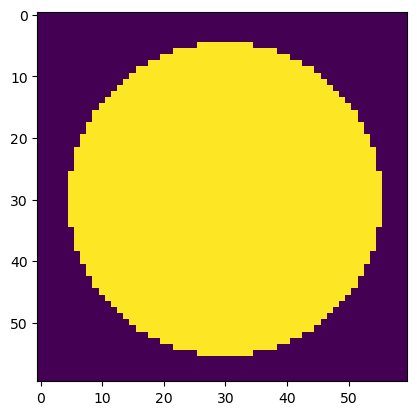

In [81]:
#  Own low pass filter of size 55
my_low_pass = create_filter(55, 255, 0)
plt.imshow(my_low_pass)

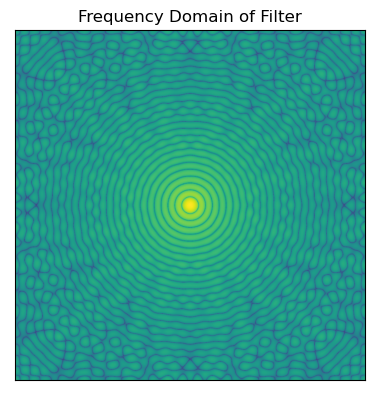

In [82]:
my_lp_spectrum = img_to_freq(my_low_pass)
show_images(1, 500, (convert_freq(img_to_freq(my_low_pass, 1024)), "Frequency Domain of Filter"), title=True)

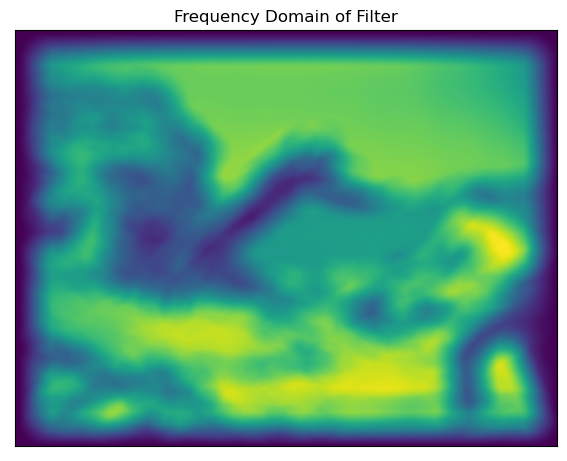

In [83]:
# Apply low pass filter
spectrum_desert = img_to_freq(desert)
my_filter_spectrum = img_to_freq(my_low_pass, max(desert.shape))

show_images(1, 700, (apply_freq_filter(desert, my_low_pass)[:desert.shape[0]+ 55, :desert.shape[1] + 55], "Frequency Domain of Filter"), title=True)



In [84]:
# Butterworthfilter

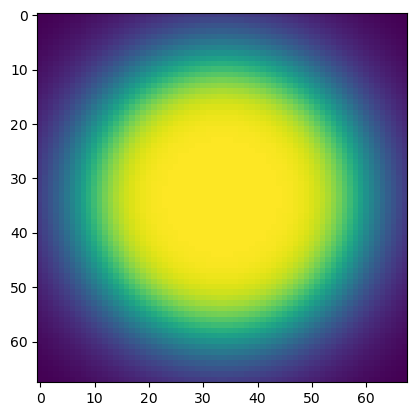

In [85]:
# Butterworth
# For counteracting the ringing effect
def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def butterworthLP(D0,n):
    size = int(3 * D0)
    shape = (size, size)
    base = np.zeros(shape)
    rows, cols = shape
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = 1/(1+(distance((y,x),center)/D0)**(2*n))

    # cropping out the black pixels. E.g. tolerance 0.2
    return crop_image(base, 0.2)

bw_lp = butterworthLP(27, 3)
plt.imshow(bw_lp)

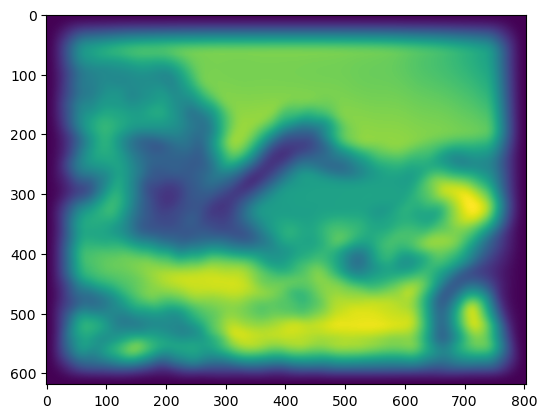

In [86]:
filtered = apply_freq_filter(desert, bw_lp)
plt.imshow(crop_image(filtered, .2))

In [87]:
# Filtering without frequency Domain
size = 15
averaging_filter = np.ones((size,size)) / (size*size)

def _pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def pad_border(img, border_size):
    return np.pad(img, int(border_size), _pad_with)

def get_neighbours(img, y, x, size):
    result = np.zeros((size, size))
    h_size = int((size - 1) / 2)
    return img[y-h_size:y+h_size+1,x-h_size:x+h_size+1]

def apply_filter(img, my_filter):
    new_img = img.copy()
    filter_size = my_filter.shape[0]
    pad_size = int((filter_size-1)/2)
    padded_img = pad_border(img, pad_size)
    for x,y in np.ndindex(img.shape):
        neighbours = get_neighbours(padded_img, x+pad_size, y+pad_size, filter_size)
        convolution = np.multiply(neighbours, my_filter)
        new_img[x,y] = np.sum(convolution)
    return np.abs(new_img)

CPU times: user 4.47 s, sys: 34 ms, total: 4.51 s
Wall time: 4.55 s


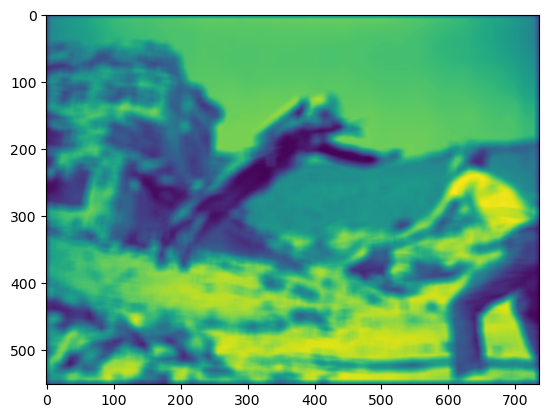

In [88]:
get_ipython().run_cell_magic('time',
                             '',
                             'size = 15'
                             '\n'
                             'averaging_filter = np.ones((size,size)) / (size*size)'
                             '\n'
                             '\n'
                             'no_frequ_15 = apply_filter(desert, averaging_filter)'
                              '\n'
                              'plt.imshow(no_frequ_15)')

CPU times: user 7.24 s, sys: 56.2 ms, total: 7.3 s
Wall time: 7.48 s


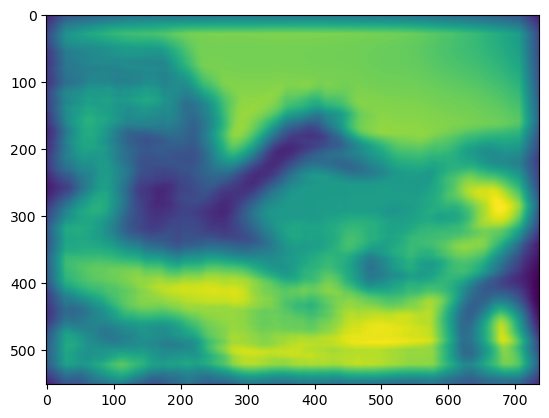

In [89]:
get_ipython().run_cell_magic('time',
                             '',
                             'size = (15 * 4) -1'
                             '\n'
                             'averaging_filter = np.ones((size,size)) / (size*size)'
                             '\n'
                             '\n'
                             'no_frequ_60 = apply_filter(desert, averaging_filter)'
                             '\n'
                             'plt.imshow(no_frequ_60)')


CPU times: user 98.4 ms, sys: 9.33 ms, total: 108 ms
Wall time: 107 ms


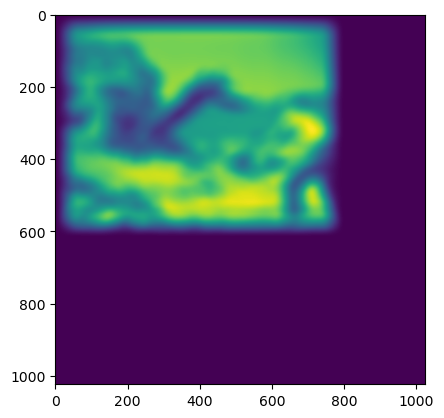

In [90]:
# Frequency domain
get_ipython().run_cell_magic('time',
                             '',
                             '\n'
                             'bw_lp = butterworthLP(26, 3)'
                             '\n'
                             'frequ_15 = apply_freq_filter(desert, bw_lp)'
                             '\n'
                             'plt.imshow(frequ_15)')

CPU times: user 86.1 ms, sys: 8.95 ms, total: 95 ms
Wall time: 93.4 ms


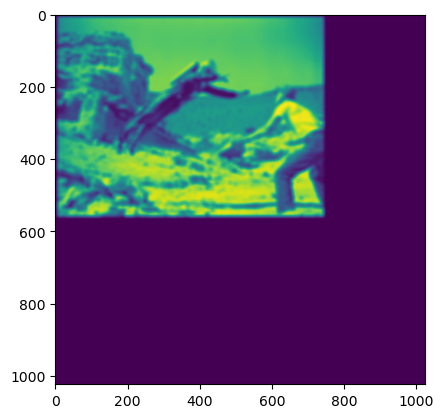

In [91]:
get_ipython().run_cell_magic('time',
                             '',
                             '\n'
                             'ft = butterworthLP(26/4, 3)'
                             '\n'
                             'frequ_60 = apply_freq_filter(desert, ft)'
                             '\np'
                             'lt.imshow(frequ_60)')

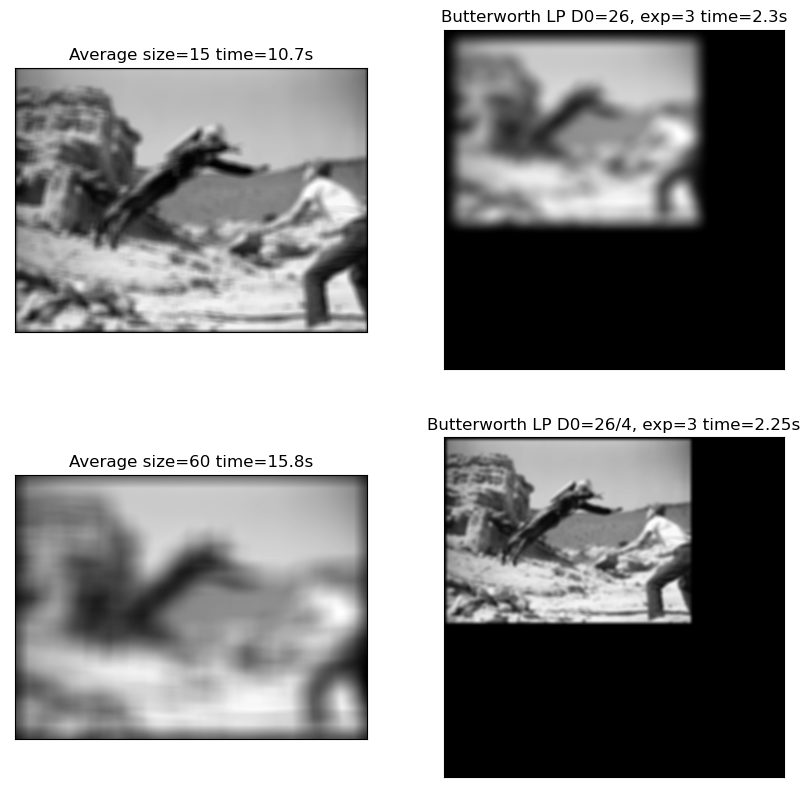

In [92]:
# Results
size = 15
averaging_filter = np.ones((size,size)) / (size*size)
no_frequ_15 = apply_filter(desert, averaging_filter)

bw_lp = butterworthLP(26, 3)
frequ_15 = apply_freq_filter(desert, bw_lp)

size = (15 * 4) -1
averaging_filter = np.ones((size,size)) / (size*size)
no_frequ_60 = apply_filter(desert, averaging_filter)

ft = butterworthLP(26/4, 3)
frequ_60 = apply_freq_filter(desert, ft)

show_images(2, 500, (no_frequ_15, f"Average size=15 time=10.7s"),
            (frequ_15, "Butterworth LP D0=26, exp=3 time=2.3s"),
            (no_frequ_60, "Average size=60 time=15.8s"),
            (frequ_60, "Butterworth LP D0=26/4, exp=3 time=2.25s"),
            cmap="gray", title=True)

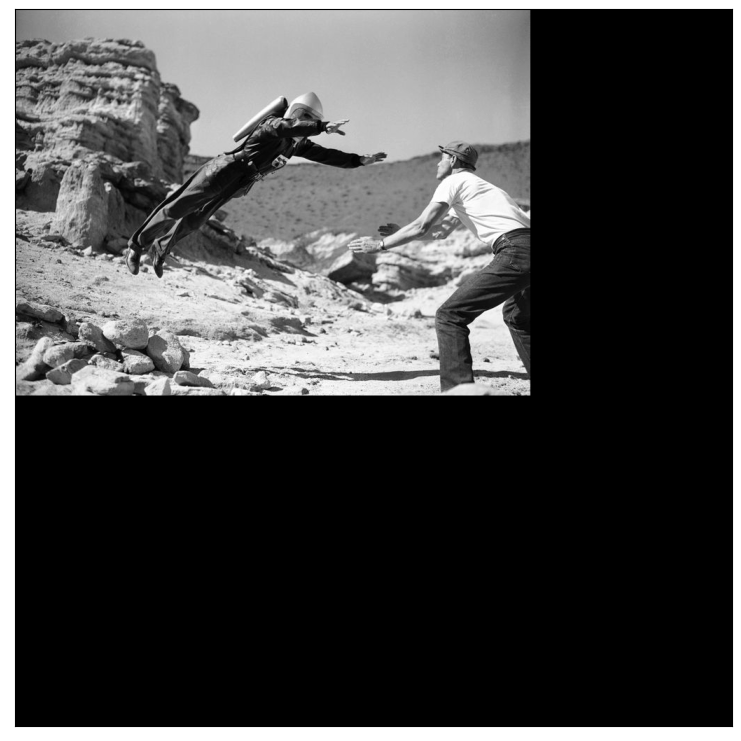

In [93]:
# Wiener filter I
img = desert
freq = img_to_freq(img)
img = freq_to_img(freq)
show_images(1, 1024, img, cmap="gray")

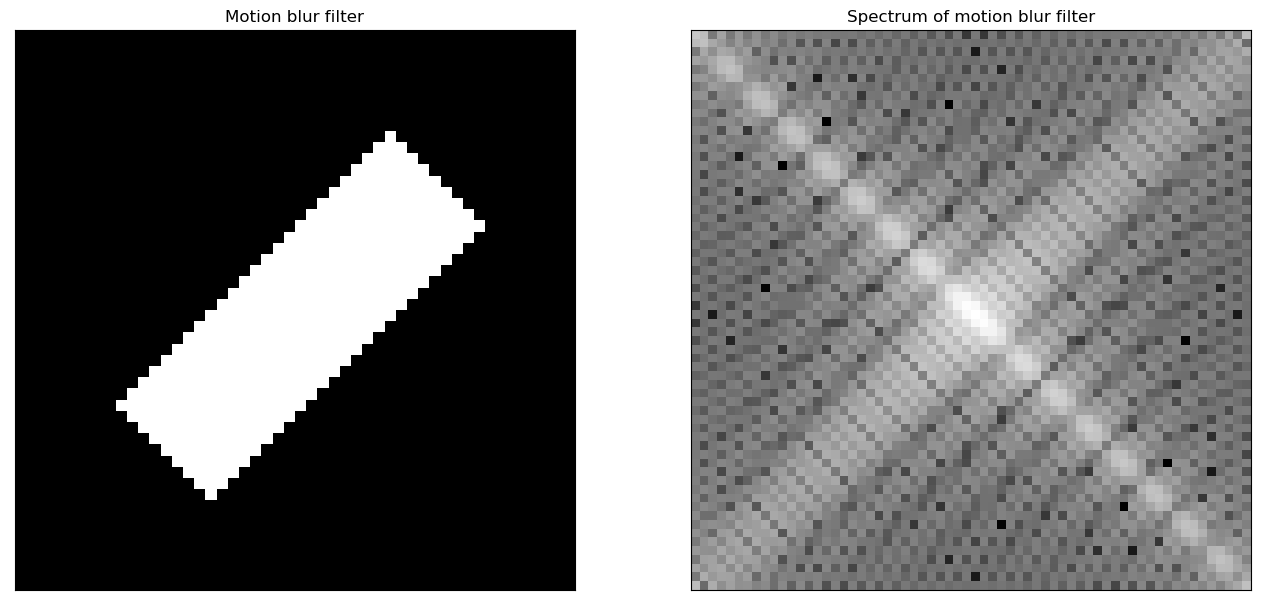

In [94]:
# Motion blur filter
blur_length= 12
blur_width = 12

img_shape = (50, 50)
blk = (0)
wht = (255)

def blip(drawing, x, y, size, col):
    draw.ellipse((y-size, x-size, y+size, x+size), fill=col)

# Color mode L = 8 bit pixels, black and white
filter_img = Image.new('L', (img_shape), blk)
draw = ImageDraw.Draw(filter_img)

img_center = (int(img_shape[0])/2, int(img_shape[1]/2))
pos_line = (img_center, (img_center[0] + blur_length, img_center[1] - blur_length))
neg_line = (img_center, (img_center[0] - blur_length, img_center[1] + blur_length))

draw.line(pos_line, fill=wht, width=blur_width)
draw.line(neg_line, fill=wht, width=blur_width)

my_filter = np.transpose(np.array(filter_img))

show_images(2, 800,
            (my_filter, "Motion blur filter"),
            (convert_freq(img_to_freq(my_filter)), "Spectrum of motion blur filter"),
            cmap="gray", title=True)

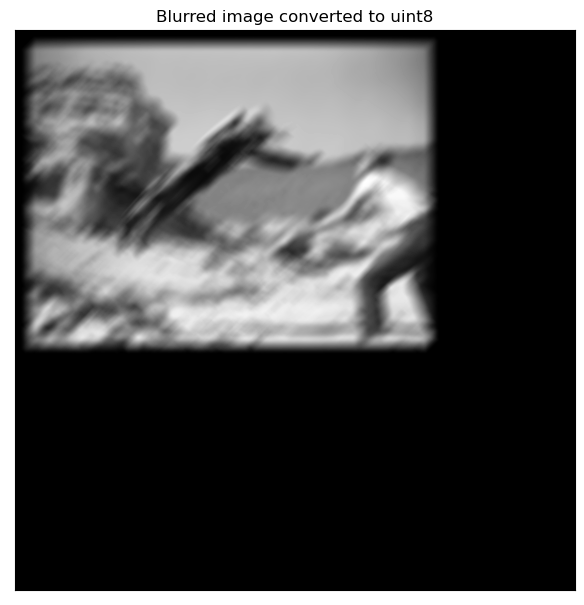

In [95]:
img_spectrum = img_to_freq(img)
my_filter_spectrum = img_to_freq(my_filter)
motion_blured_image = apply_freq_filter(img, my_filter)
motion_blured_image = convert(motion_blured_image, 0, 255, np.uint8)
show_images(1, 800, (motion_blured_image, 'Blurred image converted to uint8') , cmap="gray", title = True)

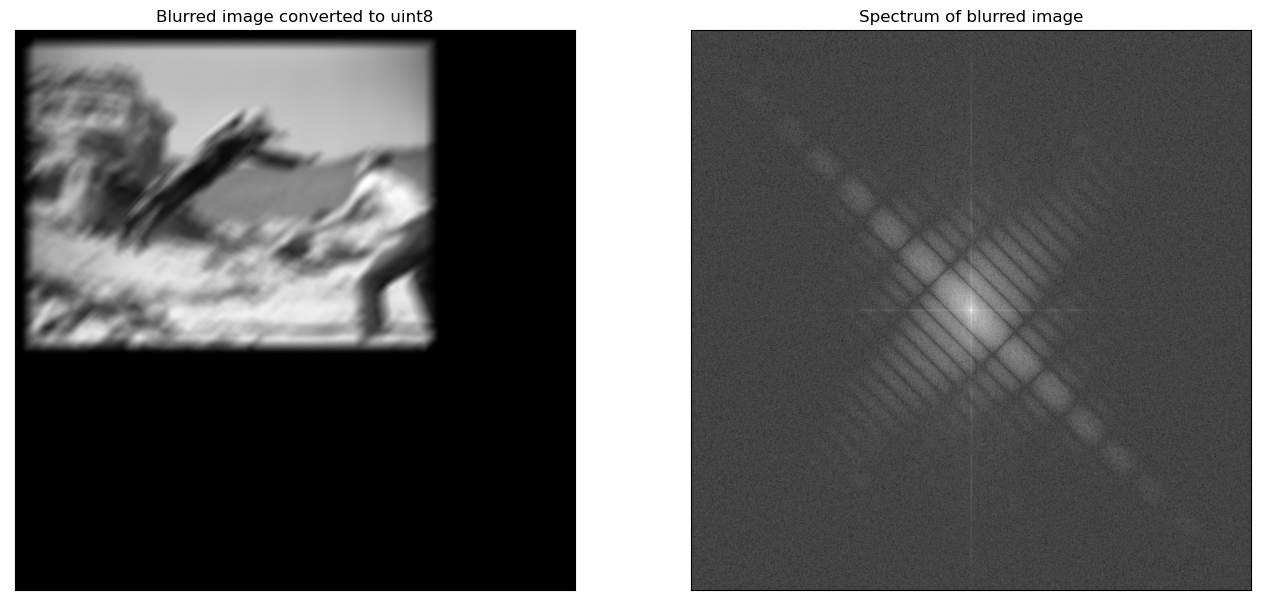

In [96]:
img_spectrum = img_to_freq(img)
my_filter_spectrum = img_to_freq(my_filter, np.max(img.shape))
distorted_img_spectrum_f = img_spectrum * my_filter_spectrum
distorted_img_f = freq_to_img(distorted_img_spectrum_f)
distorted_img = convert(distorted_img_f, 0, 255, np.uint8)
distorted_img_spectrum = img_to_freq(distorted_img)

show_images(2, 800,
            (distorted_img, "Blurred image converted to uint8"),
            (convert_freq(distorted_img_spectrum), "Spectrum of blurred image"),
            cmap="gray", title=True)

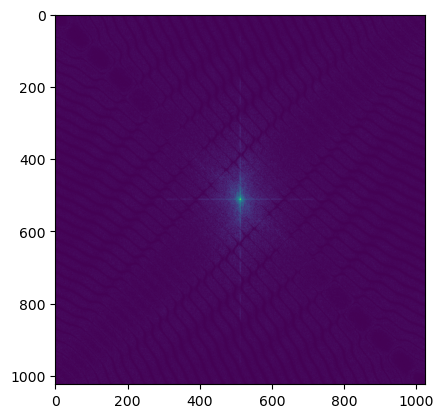

In [97]:
# Wiener Filter I
def wiener_filter(image_spectrum, filter_spectrum, K):
    return np.conjugate(filter_spectrum) * image_spectrum / (np.power(np.abs(filter_spectrum), 2.0) + K)

reconstructed_spectrum = wiener_filter(distorted_img_spectrum, my_filter_spectrum, 300000)
show_spectrum(reconstructed_spectrum)

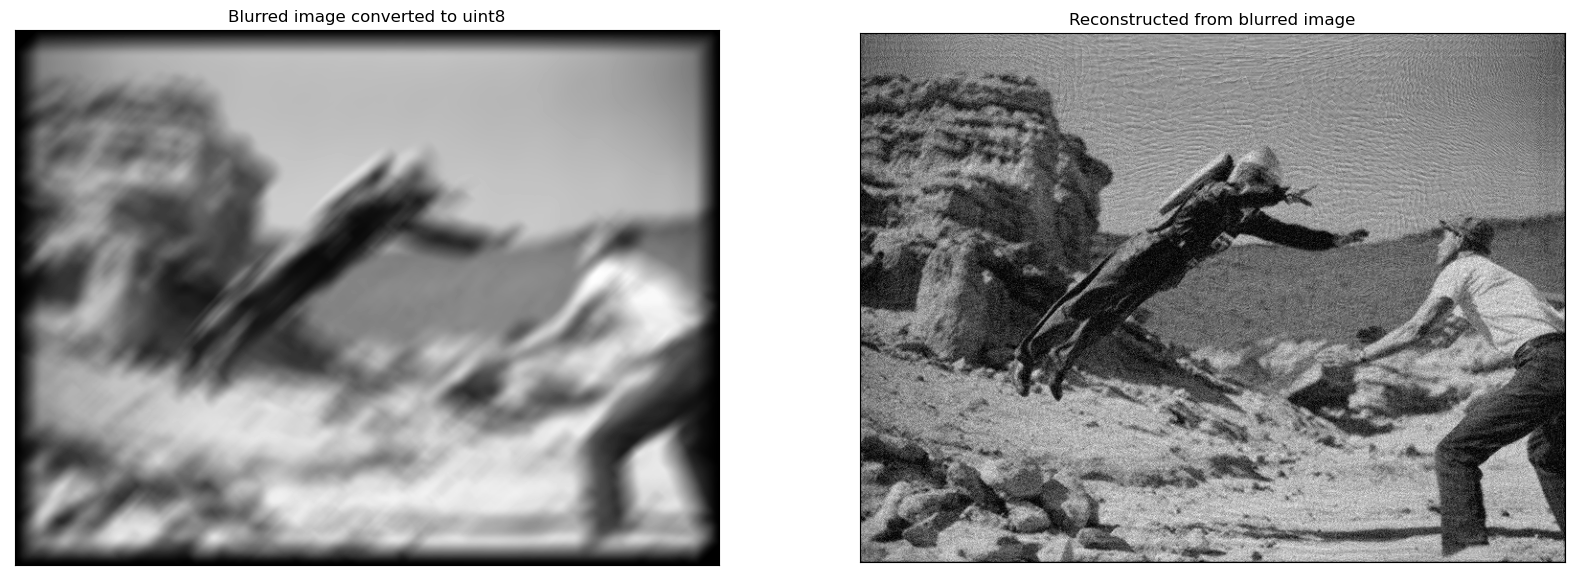

In [98]:
reconstructed_img = np.real(freq_to_img(reconstructed_spectrum))
show_images(2, 1000, (crop_image(distorted_img,.2), "Blurred image converted to uint8"), (reconstructed_img[:552, :736], "Reconstructed from blurred image"),
            cmap="gray", title=True)

filename: pics/blurred_image.jpg
file format: JPEG
dtype: uint8
shape: (688, 506)



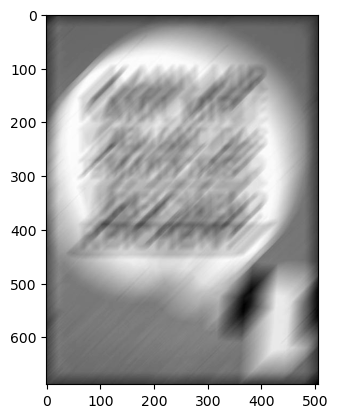

In [99]:
# Wiener filter II
def wiener_filter(image_spectrum, filter_spectrum, K):
    return np.conjugate(filter_spectrum) * image_spectrum / (np.power(np.abs(filter_spectrum), 2.0) + K)

file_name = 'pics/blurred_image.jpg'

blurred_image = get_image_array(file_name, True)
# The following is not need because it is already a gray image
#blurred_image = rgb2gray(blurred_image)
plt.imshow(blurred_image, cmap="gray")

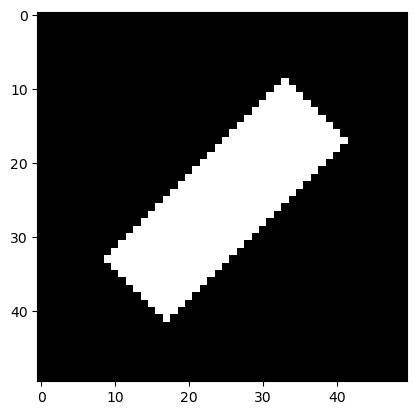

In [100]:
# Real filter image
plt.imshow(my_filter, cmap="gray")

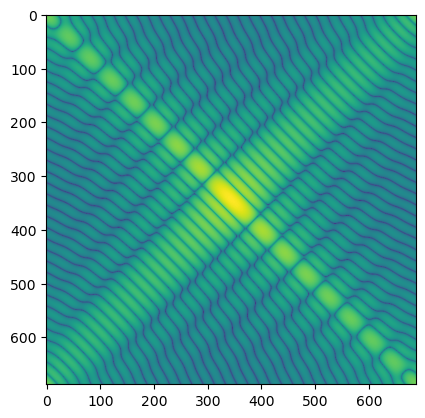

In [101]:
# Real space filter image to frequency filter image
my_filter_spectrum = img_to_freq(my_filter, np.max(blurred_image.shape))
show_spectrum(my_filter_spectrum)

In [102]:
### Cell is not functional
blurred_image = convert(blurred_image, 0, 255, np.uint8)
blurred_image_spectrum = img_to_freq(blurred_image)

reconstructed_spectrum = wiener_filter(blurred_image_spectrum, my_filter_spectrum, 300000)

ValueError: operands could not be broadcast together with shapes (688,688) (1024,1024) 

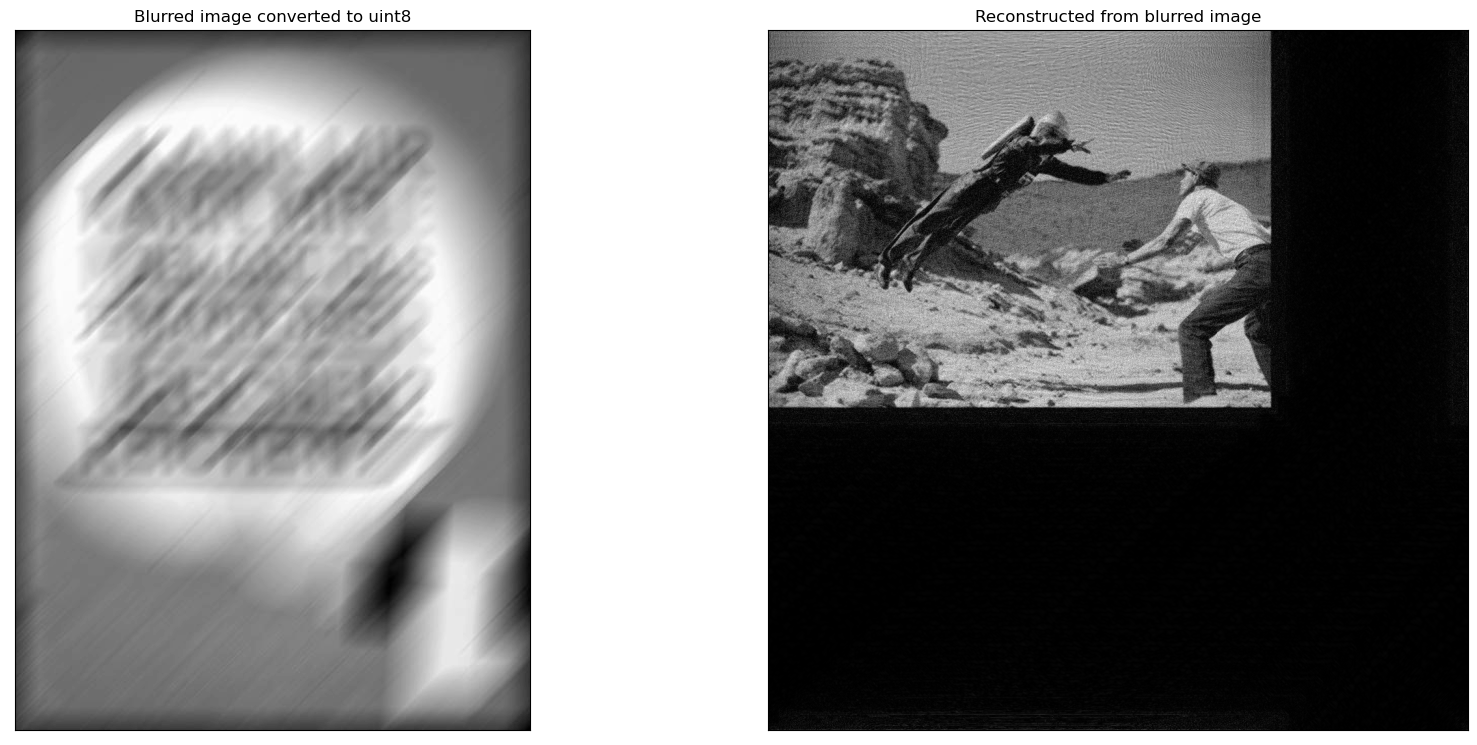

In [103]:
### Cell dependend of cell above --> Thus, result not (yet) correct
reconstructed_img = np.real(freq_to_img(reconstructed_spectrum))
show_images(2, 1000, (crop_image(blurred_image,.2), "Blurred image converted to uint8"), (reconstructed_img[:1024, :1024], "Reconstructed from blurred image"),
            cmap="gray", title=True)

# Template to fill out:
## Men in the dessert

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage, fft
from PIL import Image

In [105]:
# ----------------------------------------------------- load blurred image ---------------------------------------------
file_name = 'pics/MenInDesert.jpg'

# Open the image with pillow and convert to numpy array
image = Image.open(file_name)
color_pixels = np.asarray(Image.open(file_name))
gray_pixels = np.asarray(Image.open(file_name).convert('L'))

# summarize some details about the image
print(image.format)
print('numpy array:', gray_pixels.dtype)
print(gray_pixels.shape)

JPEG
numpy array: uint8
(552, 736)


In [106]:
# -------------------------------------------- generate the motion blur filter -----------------------------------------
nFilter = 91
angle = 30
my_filter = np.zeros((nFilter, nFilter))
my_filter[nFilter//2, :] = 1.0 / nFilter
my_filter = scipy.ndimage.rotate(my_filter, angle, reshape=False)

In [107]:
# here goes your code ...

file_name = 'pics/MenInDesert.jpg'

# Open the image with pillow and convert to numpy array
image = Image.open(file_name)
color_pixels = np.asarray(Image.open(file_name))
gray_pixels = np.asarray(Image.open(file_name).convert('L'))

# summarize some details about the image
print(image.format)
print('numpy array:', gray_pixels.dtype)
print(gray_pixels.shape)


nFilter = 91
angle = 30
my_filter = np.zeros((nFilter, nFilter))
my_filter[nFilter//2, :] = 1.0 / nFilter
my_filter = scipy.ndimage.rotate(my_filter, angle, reshape=False)

# here goes your code ...
nRows = gray_pixels.shape[0]
nCols = gray_pixels.shape[1]
nFFT = 1024

# fft returns complex numbers --> np.real
# The shape is applied of output. If bigger than input, zero padding, if smaller cropping
image_spectrum = scipy.fft.fft2(gray_pixels, (nFFT, nFFT))
filter_spectrum = scipy.fft.fft2(my_filter, (nFFT, nFFT))

modified_image_spectrum = image_spectrum * filter_spectrum
modified_image = scipy.fft.ifft2(modified_image_spectrum)
modified_image = np.real(modified_image)[nFilter:nRows + nFilter, nFilter:nCols + nFilter]

JPEG
numpy array: uint8
(552, 736)


In [108]:
# --------------------------------------------------- reconstruct the image --------------------------------------------
# here goes your code ...
def wiener_filter(distorted_img_spectrum, filter_spectrum, K):
    return np.conj(filter_spectrum) * distorted_img_spectrum / (np.abs(filter_spectrum)**2 + K)

reconstructed_image_spectrum = wiener_filter(modified_image_spectrum, filter_spectrum, 0)
reconstructed_image = scipy.fft.ifft2(reconstructed_image_spectrum)
reconstructed_image = np.real(reconstructed_image)[nFilter:nRows + nFilter, nFilter:nCols + nFilter]

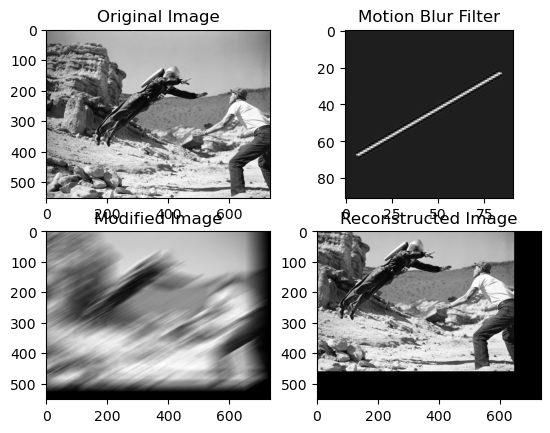

In [109]:
# --------------------------------------------------------- display images ---------------------------------------------
fig = plt.figure(1)
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(gray_pixels, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Motion Blur Filter')
plt.imshow(my_filter, cmap='gray')

plt.subplot(2, 2, 3)
plt.title('Modified Image')
plt.imshow(modified_image, cmap='gray')


plt.subplot(2, 2, 4)
plt.title('Reconstructed Image')
# here goes your reconstructed image
plt.imshow(reconstructed_image, cmap='gray')

plt.show()

# Template to fill out:
## Blurred image

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage, fft
from PIL import Image

In [111]:
# ----------------------------------------------------- load blurred image ---------------------------------------------
file_name = 'pics/blurred_image.jpg'

# Open the image with pillow and convert to numpy array
image = Image.open(file_name)
color_pixels = np.asarray(Image.open(file_name))
gray_pixels = np.asarray(Image.open(file_name).convert('L'))

# summarize some details about the image
print(image.format)
print('numpy array:', gray_pixels.dtype)
print(gray_pixels.shape)

JPEG
numpy array: uint8
(688, 506)


In [112]:
# -------------------------------------------- generate the motion blur filter -----------------------------------------
nFilter = 91
angle = 30
my_filter = np.zeros((nFilter, nFilter))
my_filter[nFilter // 2, :] = 1.0 / nFilter
my_filter = scipy.ndimage.rotate(my_filter, angle, reshape=False)

In [113]:
# here goes your code ...

file_name = 'pics/blurred_image.jpg'

# Open the image with pillow and convert to numpy array
image = Image.open(file_name)
color_pixels = np.asarray(Image.open(file_name))
gray_pixels = np.asarray(Image.open(file_name).convert('L'))

# summarize some details about the image
print(image.format)
print('numpy array:', gray_pixels.dtype)
print(gray_pixels.shape)

nFilter = 95
angle = 45
my_filter = np.zeros((nFilter, nFilter))
my_filter[nFilter//2, :] = 1.0 / nFilter
my_filter = scipy.ndimage.rotate(my_filter, angle, reshape=False)

nRows = gray_pixels.shape[0]
nCols = gray_pixels.shape[1]
nFFT = 1024

# fft returns complex numbers --> np.real
# The shape is applied of output. If bigger than input, zero padding, if smaller cropping
image_spectrum = scipy.fft.fft2(gray_pixels, (nFFT, nFFT))
filter_spectrum = scipy.fft.fft2(my_filter, (nFFT, nFFT))

JPEG
numpy array: uint8
(688, 506)


In [114]:
# --------------------------------------------------- reconstruct the image --------------------------------------------
# here goes your code ...
def wiener_filter(distorted_img_spectrum, filter_spectrum, K):
    return np.conj(filter_spectrum) * distorted_img_spectrum / (np.abs(filter_spectrum)**2 + K)

reconstructed_image_spectrum = wiener_filter(image_spectrum, filter_spectrum, 0.01)
reconstructed_image = scipy.fft.ifft2(reconstructed_image_spectrum)
reconstructed_image = np.real(reconstructed_image)[0:nRows, 0:nCols]

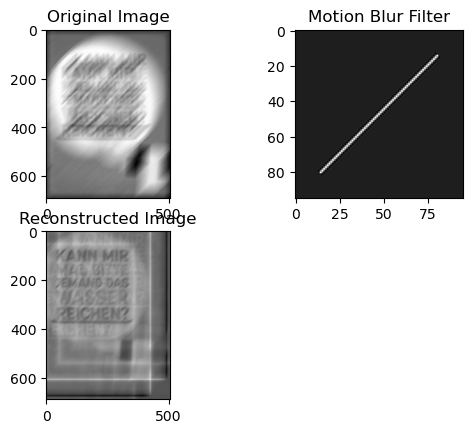

In [115]:
# --------------------------------------------------------- display images ---------------------------------------------
fig = plt.figure(1)
plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(gray_pixels, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Motion Blur Filter')
plt.imshow(my_filter, cmap='gray')

plt.subplot(2, 2, 3)
plt.title('Reconstructed Image')
# here goes your reconstructed image
plt.imshow(reconstructed_image, cmap='gray')

# Result
## Kann mir mal bitte jemand das Wasser reichen?